In [1]:
# Gender recognition using CNN & ResNet50 (Transfer learning) 2021
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import glob
import random
from keras.optimizers import Adam
from keras.models import Sequential,load_model,Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input,Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# config
path = "data/gender_dataset_face"
img_height = 96
img_width = 96
batch_size = 64
images = []
labels = []

In [3]:
# load images in the dataset
image_files = [f for f in glob.glob(path + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [4]:
# images and labels
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_width,img_height))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    images.append(np.array(image))

    label = img.split(os.path.sep)[-2] # gender_dataset_face\woman\img
    if label == "woman":
        label = 1
    else:
        label = 0
    labels.append([label])

In [5]:
# pre-processing
images = np.array(images, dtype="float") / 255.0
labels = np.array(labels,dtype=np.uint64)

In [6]:
# split data into training & testing
(x_train, x_test, y_train, y_test) = train_test_split(images, labels,test_size=0.3, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [7]:
augmentation = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

In [9]:
# CNN model
model_g = Sequential()

#1st layer
model_g.add(Conv2D(64,(3,3),padding = 'same',input_shape = (img_width,img_height,3)))
model_g.add(Activation('relu'))
model_g.add(MaxPooling2D(pool_size = (2,2)))
model_g.add(Dropout(0.25))

#2nd layer
model_g.add(Conv2D(128,(5,5),padding = 'same'))
model_g.add(Activation('relu'))
model_g.add(MaxPooling2D(pool_size = (2,2)))
model_g.add(Dropout (0.25))

#3rd layer
model_g.add(Conv2D(512,(3,3),padding = 'same'))
model_g.add(Activation('relu'))
model_g.add(MaxPooling2D(pool_size = (2,2)))
model_g.add(Dropout (0.25))

#4th layer
model_g.add(Conv2D(512,(3,3), padding='same'))
model_g.add(Activation('relu'))
model_g.add(MaxPooling2D(pool_size=(2, 2)))
model_g.add(Dropout(0.25))

model_g.add(Flatten())

#Fully connected 1st layer
model_g.add(Dense(256))
model_g.add(Activation('relu'))
model_g.add(Dropout(0.25))

# Fully connected layer 2nd layer
model_g.add(Dense(512))
model_g.add(BatchNormalization())
model_g.add(Activation('relu'))
model_g.add(Dropout(0.25))

model_g.add(Dense(2, activation='sigmoid'))
model_g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 activation (Activation)     (None, 96, 96, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       204928    
                                                                 
 activation_1 (Activation)   (None, 48, 48, 128)       0         
                                                        

In [10]:
# compile the model
model_g.compile(loss="binary_crossentropy", optimizer = Adam(lr=0.001), metrics=["accuracy"])

checkpoint = ModelCheckpoint("./models/Gender_CNN_model.model", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=3, verbose=1, restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

c:\Users\D.azad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# train the model
history_g = model_g.fit_generator(augmentation.flow(x_train, y_train, batch_size=batch_size), validation_data=(x_test,y_test), steps_per_epoch=len(x_train) // batch_size, epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50


C:\Users\D.azad\AppData\Local\Temp\ipykernel_21916\691545324.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_g = model_g.fit_generator(augmentation.flow(x_train, y_train, batch_size=batch_size), validation_data=(x_test,y_test), steps_per_epoch=len(x_train) // batch_size, epochs=50, verbose=1, callbacks=callbacks_list)


25/25 [==============================] - 8s 169ms/step - loss: 0.7562 - accuracy: 0.5697 - val_loss: 0.9912 - val_accuracy: 0.5166 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 2s 98ms/step - loss: 0.6782 - accuracy: 0.6368 - val_loss: 0.7766 - val_accuracy: 0.4993 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 2s 97ms/step - loss: 0.6288 - accuracy: 0.6832 - val_loss: 0.7232 - val_accuracy: 0.5152 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 2s 96ms/step - loss: 0.5396 - accuracy: 0.7710 - val_loss: 0.6231 - val_accuracy: 0.5570 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 2s 96ms/step - loss: 0.4746 - accuracy: 0.7865 - val_loss: 0.4849 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 2s 95ms/step - loss: 0.4468 - accuracy: 0.8052 - val_loss: 0.4496 - val_accuracy: 0.8009 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 2s 96ms/step - loss: 0.3818 - accu

In [12]:
# prediction & evaluation
results_g = model_g.evaluate(x_test,y_test)
preds_g = model_g.predict(x_test)
print(' Model accuracy {}%'.format(round(results_g[1]*100, 2)))

22/22 [==============================] - 0s 14ms/step
 Model accuracy 91.63%


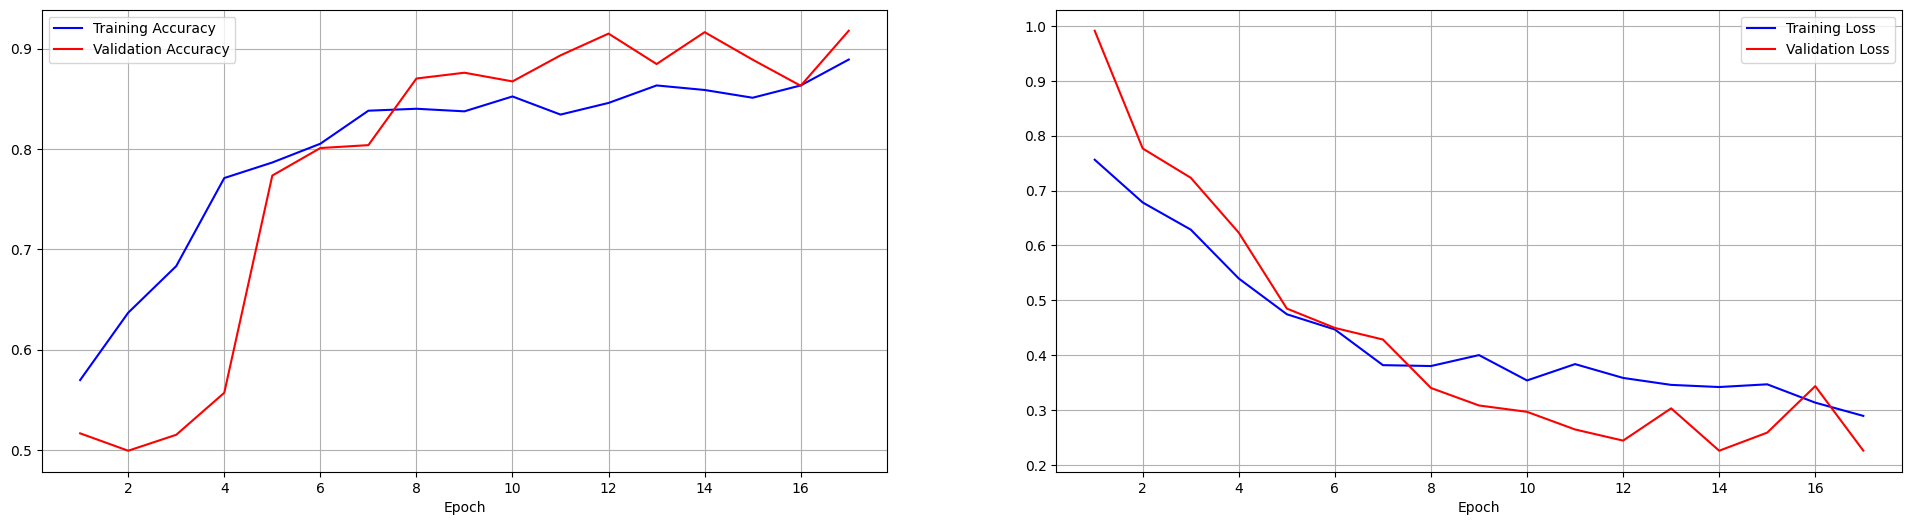

In [13]:
# visualise training and testing accuracy & loss
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()


plot_results(history_g)

In [14]:
# saving model
model_g.save("./models/Gender_CNN_model.model")

INFO:tensorflow:Assets written to: ./models/Gender_CNN_model.model\assets


INFO:tensorflow:Assets written to: ./models/Gender_CNN_model.model\assets


In [8]:
# ResNet50 model
resnet_model = Sequential()

pretrained_model= ResNet50(include_top=False,
                   input_shape=(img_width,img_height,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='sigmoid'))

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
# compile the model
resnet_model.compile(optimizer = Adam(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint("./models/Gender_ResNet50_model.model", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=3, verbose=1, restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

c:\Users\D.azad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
# train the model
history_g_res = resnet_model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=50,callbacks=callbacks_list)

Epoch 1/50
51/51 [==============================] - 9s 79ms/step - loss: 0.7003 - accuracy: 0.5112 - val_loss: 0.6745 - val_accuracy: 0.5296 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 2s 42ms/step - loss: 0.6678 - accuracy: 0.5991 - val_loss: 0.6543 - val_accuracy: 0.5916 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 2s 40ms/step - loss: 0.6473 - accuracy: 0.6171 - val_loss: 0.7090 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 2s 42ms/step - loss: 0.6263 - accuracy: 0.6648 - val_loss: 0.6072 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 2s 41ms/step - loss: 0.5909 - accuracy: 0.7286 - val_loss: 0.5868 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 2s 42ms/step - loss: 0.5761 - accuracy: 0.7069 - val_loss: 0.5624 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 2s 42ms/step - loss: 0.5

In [11]:
# prediction & evaluation
results = resnet_model.evaluate(x_test,y_test)
preds = resnet_model.predict(x_test)
print(' Model accuracy {}%'.format(round(results[1]*100, 2)))

22/22 [==============================] - 1s 23ms/step
 Model accuracy 78.64%


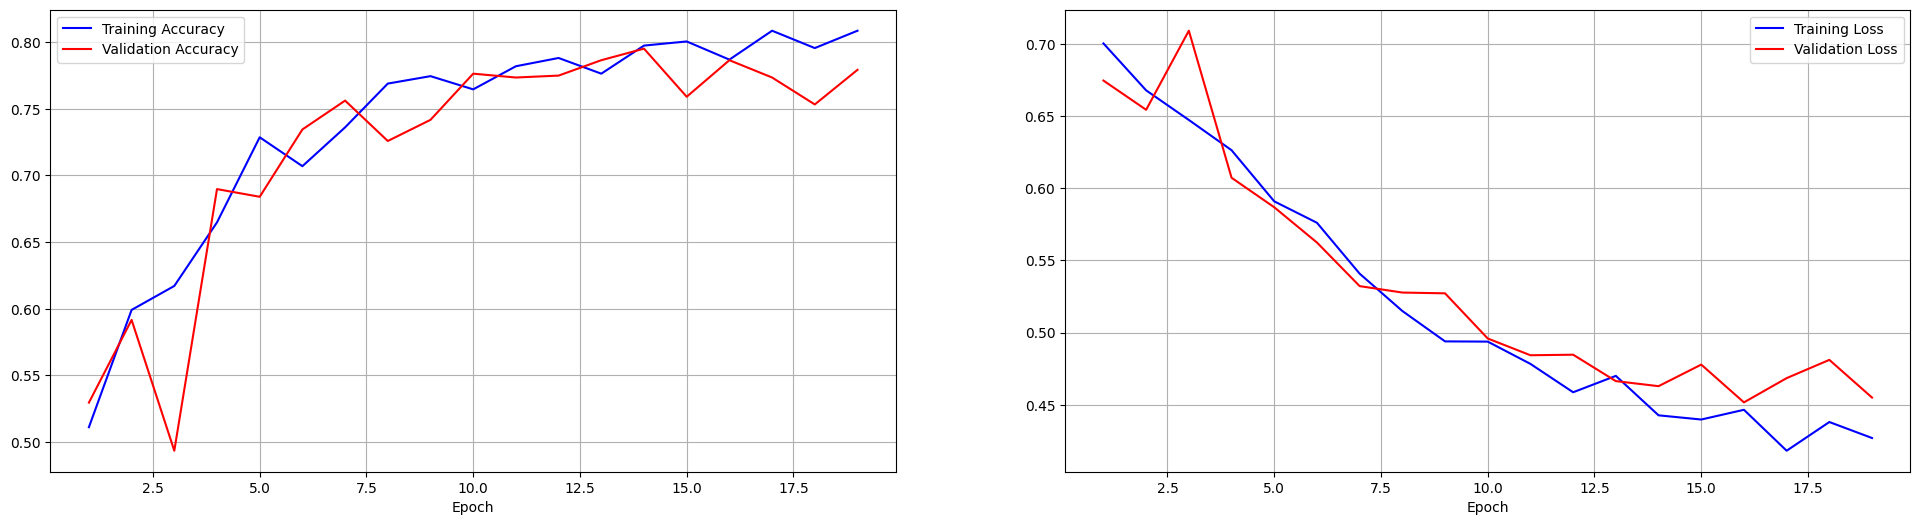

In [12]:
# visualise training and testing accuracy & loss
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()


plot_results(history_g_res)

In [13]:
# saving model
resnet_model.save("./models/Gender_ResNet50_model.model")

INFO:tensorflow:Assets written to: ./models/Gender_ResNet50_model.model\assets


INFO:tensorflow:Assets written to: ./models/Gender_ResNet50_model.model\assets


In [55]:
#Test ResNet50 model
my_Res_model = load_model('./models/Gender_ResNet50_model.h5', compile=False)

predictions_Res = my_Res_model.predict(x_test)
y_pred_Res = (predictions_Res>= 0.5).astype(int)[:,0]
y_test_p = y_test.astype(int)[:,0]
print ("Accuracy = ", metrics.accuracy_score(y_test_p, y_pred_Res))


22/22 [==============================] - 1s 22ms/step
Accuracy =  0.8311688311688312


In [56]:
print( "Actual value :" , y_test_p[8], "/ Predicted value :" , y_pred_Res[8])

Actual value : 1 / Predicted value : 1


<Axes: >

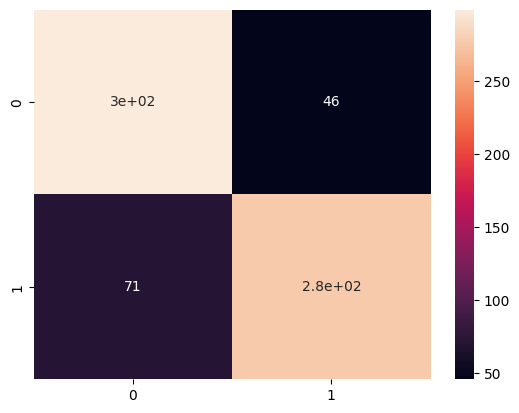

In [57]:
# confusion matrix
cm=confusion_matrix(y_test_p, y_pred_Res)  
sns.heatmap(cm, annot=True)

In [15]:
#Test CNN model
my_CNN_model = load_model('./models/Gender_CNN_model.model', compile=False)

predictions_CNN = my_CNN_model.predict(x_test)
y_pred_CNN = (predictions_CNN>= 0.5).astype(int)[:,0]
y_test_p = y_test.astype(int)[:,0]
print ("Accuracy = ", metrics.accuracy_score(y_test_p, y_pred_CNN))

22/22 [==============================] - 1s 23ms/step
Accuracy =  0.9134199134199135


In [16]:
print( "Actual value :" , y_test_p[8], "/ Predicted value :" , y_pred_CNN[8])

Actual value : 1 / Predicted value : 1


<Axes: >

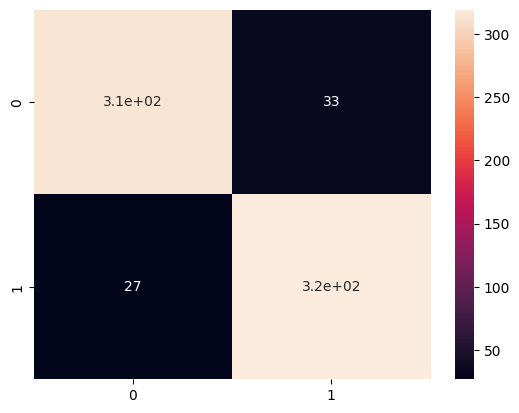

In [17]:
# confusion matrix
cm=confusion_matrix(y_test_p, y_pred_CNN)  
sns.heatmap(cm, annot=True)